In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from src.utils.preprocess import *
from src.utils.generate_driving_condition import *
from src.utils.config import *
from src.models.model import *
from src.utils.util import *

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from sklearn.model_selection import train_test_split


In [2]:
input_path="./dataset/processed/input/"
output_path="./dataset/processed/output/"
boundary_no_obs_path=input_path+"cnn_input/no_obstacle/"
driving_no_obs_path=input_path+"text_input/no_obstacle/"
label_no_obs_path=output_path+"no_obstacle/"
boundary_yes_obs_path=input_path+"cnn_input/yes_obstacle/"
driving_yes_obs_path=input_path+"text_input/yes_obstacle/"
label_yes_obs_path=output_path+"yes_obstacle/"

## 1. 데이터구성

#### 데이터로드

In [3]:
boundary_data_no_obs=np.load(boundary_no_obs_path+'boundary_condition.npy')
driving_data_no_obs=np.load(driving_no_obs_path+'driving_condition.npy')
label_data_no_obs=np.load(label_no_obs_path+'label.npy')

boundary_data_yes_obs=np.load(boundary_yes_obs_path+'boundary_condition.npy')
driving_data_yes_obs=np.load(driving_yes_obs_path+'driving_condition.npy')
label_data_yes_obs=np.load(label_yes_obs_path+'label.npy')

In [4]:
boundary_data_no_obs.shape,boundary_data_yes_obs.shape
boundary_data = np.concatenate([boundary_data_no_obs,boundary_data_yes_obs],axis=0)
driving_data = np.concatenate([driving_data_no_obs,driving_data_yes_obs],axis=0)
label_data = np.concatenate([label_data_no_obs,label_data_yes_obs],axis=0)
boundary_data.shape, driving_data.shape, label_data.shape

((423, 460800), (423, 10), (423, 120, 60, 64))

#### 데이터전처리

In [5]:
simul_config = simulaion_config()
x_dim = simul_config.x_dim
y_dim = simul_config.y_dim
z_dim = simul_config.z_dim

In [6]:
# 공간정보 데이터
boundary_data_s = []
for i in boundary_data:
    i=i.reshape(x_dim,y_dim,z_dim,1)
    boundary_data_s.append(i)
boundary_data = np.array(boundary_data_s).astype("float64")
boundary_data.shape

(423, 120, 60, 64, 1)

In [7]:
# 운전정보 데이터
char2idx,idx2char=generate_no_obstacle_operating_data()
temporary_data=driving_division(driving_data_no_obs,idx2char)
driving_config=driving_condition_max_value_config(temporary_data)
temporary_data=driving_scaling(temporary_data,driving_config)

special_token_no_obs=[]
special_value_no_obs=[]
for i in range(len(temporary_data)):
    special_token_no_obs.append(temporary_data[:,0][i])
    special_value_no_obs.append(temporary_data[:,1][i])
special_token_no_obs=np.array(special_token_no_obs)
special_value_no_obs=np.array(special_value_no_obs)

char2idx,idx2char=generate_yes_obstacle_data()
temporary_data=driving_division(driving_data_yes_obs,idx2char)
driving_config=driving_condition_max_value_config(temporary_data)
temporary_data=driving_scaling(temporary_data,driving_config)

special_token_yes_obs=[]
special_value_yes_obs=[]
for i in range(len(temporary_data)):
    special_token_yes_obs.append(temporary_data[:,0][i])
    special_value_yes_obs.append(temporary_data[:,1][i])
special_token_yes_obs=np.array(special_token_yes_obs)
special_value_yes_obs=np.array(special_value_yes_obs)

special_token = np.concatenate([special_token_no_obs,special_token_yes_obs],axis=0)
special_value = np.concatenate([special_value_no_obs,special_value_yes_obs],axis=0)
special_token.shape, special_value.shape

((423, 5), (423, 5))

In [8]:
# 레이블 데이터
max_label = np.max(label_data)
min_label = np.min(label_data)

label_data = (label_data-min_label)/(max_label-min_label)
np.max(label_data), np.min(label_data)

(1.0, 0.0)

In [9]:
boundary_data.shape, driving_data.shape, label_data.shape

((423, 120, 60, 64, 1), (423, 10), (423, 120, 60, 64))

#### 데이터분할

In [10]:
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.10
first_split_size=1-train_ratio
second_split_size=test_ratio/(test_ratio+valid_ratio)

cnn_train, cnn_tv, label_train, label_tv = train_test_split(boundary_data, label_data, test_size=first_split_size, random_state=42)
cnn_val, cnn_test, label_val, label_test = train_test_split(cnn_tv, label_tv, test_size=second_split_size, random_state=42)
spe_tok_train, spe_tok_tv, val_tok_train, val_tok_tv = train_test_split(special_token, special_value, test_size=first_split_size, random_state=42)
spe_tok_val, spe_tok_test, val_tok_val, val_tok_test = train_test_split(spe_tok_tv, val_tok_tv, test_size=second_split_size, random_state=42)

#### 데이터구성

In [11]:
X_train = [cnn_train, spe_tok_train, val_tok_train]
X_test = [cnn_test, spe_tok_test, val_tok_test]
X_val = [cnn_val, spe_tok_val, val_tok_val]
Y_train = label_train
Y_test = label_test
Y_val = label_val
print("X_train ",X_train[0].shape)
print("X_val ",X_val[0].shape)
print("X_test ",X_test[0].shape)
print("Y_train ",Y_train.shape)
print("Y_val ",Y_val.shape)
print("Y_test ",Y_test.shape,'\n')

X_train  (317, 120, 60, 64, 1)
X_val  (63, 120, 60, 64, 1)
X_test  (43, 120, 60, 64, 1)
Y_train  (317, 120, 60, 64)
Y_val  (63, 120, 60, 64)
Y_test  (43, 120, 60, 64) 



In [12]:
cnn_test.shape,spe_tok_test.shape,val_tok_test.shape

((43, 120, 60, 64, 1), (43, 5), (43, 5))

## 2. 모델구성

#### 모델정의

In [13]:
model_config=get_transformer_config()

In [14]:
model=CFDUnet(model_config)

#### 모델 컴파일

In [15]:
def L2_loss(y_true,y_pred):
    error = tf.math.square(y_true-y_pred)
    loss = tf.reduce_sum(error)
    return loss

In [16]:
initial_learning_rate = 1e-5

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss=L2_loss,
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mae","mse"],
)

#### 모델 경로지정

In [17]:
# 모델 저장 경로정의
WEIGHT_PATH = 'checkpoints/'
model_name = 'transUnet/'
test_num = 'total'
TEST_DIR = 'TEST' + str(test_num) + '/'

# 경로지정
checkpoint_path = WEIGHT_PATH + model_name + TEST_DIR + "TEST" + str(test_num)
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

checkpoints/transUnet/TESTtotal -- Folder already exists 



#### callback 함수 지정

In [18]:
# EarlyStopping
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=50)

# Tensorboard
log_dir = "logs/fit/" + 'TEST' + str(test_num) + "" 

if os.path.exists(log_dir):
    print("{} -- Folder already exists \n".format(log_dir))
else:
    os.makedirs(log_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(log_dir))
    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

logs/fit/TESTtotal -- Folder already exists 



## 3. 학습

In [19]:
# BATCH_SIZE = 1

In [20]:
# history = model.fit(X_train, Y_train, 
#                       validation_data=(X_val,Y_val),
#                       batch_size=BATCH_SIZE, epochs=1000,
#                       callbacks=[earlystop_callback, cp_callback, tensorboard_callback])

## 4. 학습결과 확인

In [21]:
# %load_ext tensorboard

In [22]:
# %tensorboard --logdir logs/fit --host localhost --port 8888

## 5. 테스트

In [23]:
checkpoint_path

'checkpoints/transUnet/TESTtotal/TESTtotal'

In [24]:
model.load_weights(checkpoint_path)

In [25]:
prediction = model.predict(X_test,batch_size=1)

#### 역스케일링 및 차원통일

In [26]:
for num in range(len(prediction)):
    prediction[num]=(prediction[num]*(max_label-min_label)+min_label)
    Y_test[num]=(Y_test[num]*(max_label-min_label)+min_label)

prediction=np.squeeze(prediction)
Y_test=np.squeeze(Y_test)
print(prediction.shape)
print(Y_test.shape)

(43, 120, 60, 64)
(43, 120, 60, 64)


#### 플로팅 1) scatter

In [27]:
# 플로팅시 사용될 데이터프레임
def plus_info_dataframe(lst,obs):
    lst = np.arange(0,len(lst),1)
    lst = list(map(lambda x:obs+"_"+str(x)+".csv",lst))
    return lst

no_obs_csv_lst = os.listdir("dataset/dataframe/no_obstacle/")
no_obs_csv_lst = plus_info_dataframe(no_obs_csv_lst,"no")
yes_obs_csv_lst = os.listdir("dataset/dataframe/yes_obstacle/")
yes_obs_csv_lst = plus_info_dataframe(yes_obs_csv_lst,"yes")

csv_lst = no_obs_csv_lst + yes_obs_csv_lst

# 데이터프레임 분할
df_train, df_tv = train_test_split(csv_lst, test_size=first_split_size, random_state=42)
df_val, df_test = train_test_split(df_tv, test_size=second_split_size, random_state=42)

# 시뮬레이션 운전조건 확인위한 데이터프레임
simulation_df_no_obs = pd.read_csv("src/data/simulation/processed/no_obstacle.csv")
simulation_df_yes_obs = pd.read_csv("src/data/simulation/processed/yes_obstacle.csv")

장애물있는 데이터입니다.
========시뮬레이션 조건========
File name            Case355
inlet_velocity          1.43
inlet_temperature         10
wall_temperature          30
Angle                     30
Name: 54, dtype: object
======== 공간구조 확인 ========


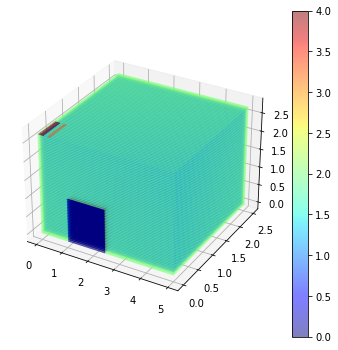

In [29]:
plot_num = 5
df = check_simulation_info(plot_num,df_test,simulation_df_no_obs,simulation_df_yes_obs,cnn_test)

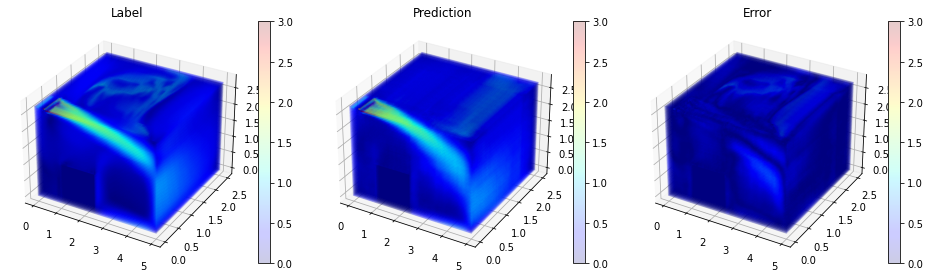

In [30]:
fig = plt.figure(figsize=(16,10))

# Label
ax = fig.add_subplot(131, projection='3d')
plt.title('Label')
im=ax.scatter(df['x'], df['y'], df['z'], c=Y_test[plot_num], s=1, alpha=0.2, cmap='jet', vmin=0, vmax=3)
plt.colorbar(im, fraction=0.046, pad=0.04)

# Prediction
ax = fig.add_subplot(132, projection='3d')
plt.title('Prediction')
im=ax.scatter(df['x'], df['y'], df['z'], c=prediction[plot_num], s=1, alpha=0.2, cmap='jet', vmin=0, vmax=3)
plt.colorbar(im, fraction=0.046, pad=0.04)

# Error
ax = fig.add_subplot(133, projection='3d')
plt.title('Error')
error=abs((Y_test[plot_num]-prediction[plot_num]))
im=ax.scatter(df['x'], df['y'], df['z'], c=error, s=1, alpha=0.2, cmap='jet', vmin=0, vmax=3)
plt.colorbar(im, fraction=0.046, pad=0.04)

#### 플로팅 2) pyvista

In [31]:
# # 레이블
# opt_list=[0.2,2.5,5,0.5,0,3]
# plot=Y_test[plot_num].reshape(x_dim*y_dim*z_dim)
# array_list=[df["x"].values,df["y"].values,df["z"].values]
# pyvista_plot(plot,opt_list,array_list)

In [32]:
# # Prediction
# opt_list=[0.2,1.9,5,0.5,0,3]
# plot=prediction[plot_num].reshape(x_dim*y_dim*z_dim)
# array_list=[df["x"].values,df["y"].values,df["z"].values]
# pyvista_plot(plot,opt_list,array_list)

## 6. 성능검증

### 분석1. 회귀선

In [33]:
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.metrics import mean_squared_error

num = 1
y_label = Y_test[num].reshape(x_dim*y_dim*z_dim)
y_pre = prediction[num].reshape(x_dim*y_dim*z_dim)
print(f"레이블 최소 : {np.min(y_label)} 레이블 최대 : {np.max(y_label)}")
print(f"예측값 최소 : {np.min(y_pre)} 예측값 최대 : {np.max(y_pre)}")

레이블 최소 : 0.000424820726 레이블 최대 : 2.18186903
예측값 최소 : -0.0014321133494377136 예측값 최대 : 2.3775782585144043


In [34]:
r2_scores = []
rmse_lst = []
for num in range(len(Y_test)):
    r2_label = Y_test[num].reshape(x_dim*y_dim*z_dim)
    r2_pred = prediction[num].reshape(x_dim*y_dim*z_dim)
    r2_scores.append(r2_score(r2_label,r2_pred))
    rmse = np.sqrt(mean_squared_error(r2_label,r2_pred))
    rmse_lst.append(rmse)
print(f" R2 score 평균점수 : {np.average(r2_scores)}")
print(f" RMSE 평균 : {np.average(rmse_lst)}")

 R2 score 평균점수 : 0.8615635135182758
 RMSE 평균 : 0.05871434554096922


기본 데이터 값에 대한 회귀선 플롯

<Figure size 864x720 with 0 Axes>

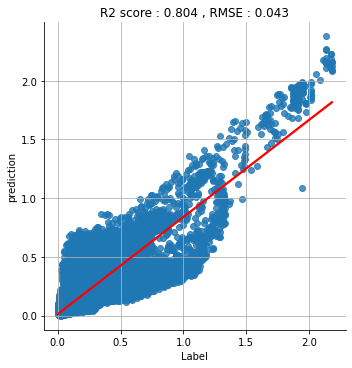

In [35]:
reg_df = pd.DataFrame({"label":y_label,"prediction":y_pre})
r2score = np.round(r2_score(y_label,y_pre),3)
rmse = np.round(np.sqrt(mean_squared_error(y_label,y_pre)),3)

plt.figure(figsize=[12,10])
ax = sns.lmplot(x="label", y="prediction", data=reg_df, line_kws = {'color' : 'red'})
plt.xlabel("Label")
plt.ylabel("prediction")
plt.title(f"R2 score : {r2score} , RMSE : {rmse}")
plt.grid()

특정부분 제외한 데이터에 대해 회귀선 플롯

<Figure size 864x720 with 0 Axes>

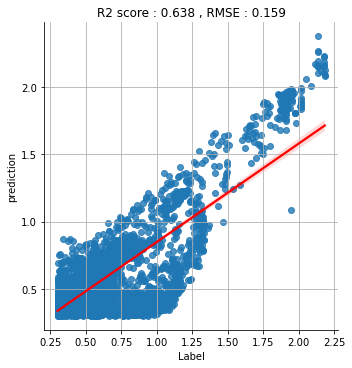

In [36]:
reg_df_ignore_inlet = reg_df[(reg_df["label"]>=0.3) & (reg_df["prediction"]>=0.3)]
r2score = np.round(r2_score(reg_df_ignore_inlet["label"],reg_df_ignore_inlet["prediction"]),3)
rmse = np.round(np.sqrt(mean_squared_error(reg_df_ignore_inlet["label"],reg_df_ignore_inlet["prediction"])),3)

plt.figure(figsize=[12,10])
ax = sns.lmplot(x="label", y="prediction", data=reg_df_ignore_inlet, line_kws = {'color' : 'red'})
plt.xlabel("Label")
plt.ylabel("prediction")
plt.title(f"R2 score : {r2score} , RMSE : {rmse}")
plt.grid()

### 분석2. 단면확인 

no_3.csv
장애물있는 데이터입니다.
========시뮬레이션 조건========
File name            Case304
inlet_velocity          1.43
inlet_temperature         10
wall_temperature          30
Angle                     50
Name: 3, dtype: object
======== 공간구조 확인 ========


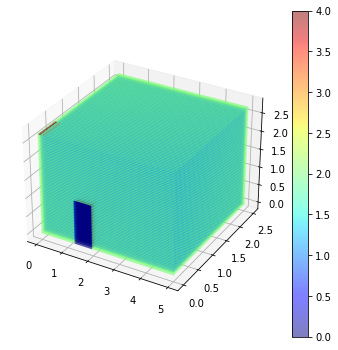

In [37]:
plot_num = 3
print(csv_lst[plot_num])
df = check_simulation_info(plot_num,csv_lst[plot_num],simulation_df_no_obs,simulation_df_yes_obs,cnn_test)

In [38]:
df["prediction"]=prediction[plot_num].reshape(x_dim*y_dim*z_dim)
df["label"]=Y_test[plot_num].reshape(x_dim*y_dim*z_dim)

position_y = 0
default_y = sorted(list(set(df["y"]))) # 고정될 y값 (xz 단면을 보기위해)
condition_y = df["y"]==default_y[position_y] # y 조건 정의
x = df[condition_y]["x"]
z = df[condition_y]["z"]
pred = df[condition_y]["prediction"]
label = df[condition_y]["label"]

vmax_value = max(np.max(label),np.max(pred))
vmin_value = min(np.min(label),np.min(pred))
vmax_value,vmin_value

(3.030644894, -0.025632119)

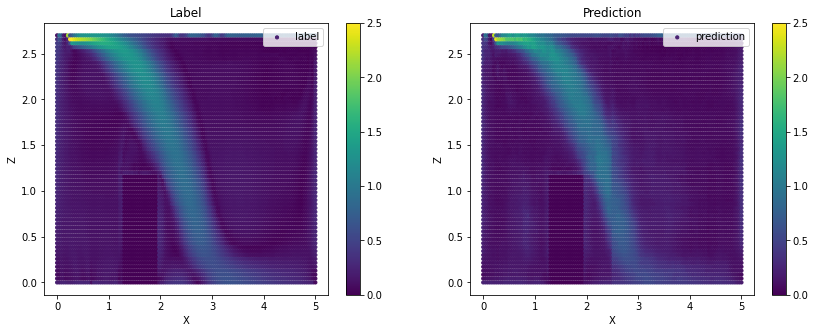

In [39]:
plt.figure(figsize=[14,5])

plt.subplot(1,2,1)
plt.scatter(x,z,c=label,marker="o",s=10, label="label", vmin=0, vmax=2.5)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Label")
plt.legend()
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(x,z,c=pred, marker="o",s=10, label="prediction", vmin=0, vmax=2.5)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Prediction")
plt.legend()
plt.colorbar()

### 분석 3. 라인확인

Text(0, 0.5, 'Value')

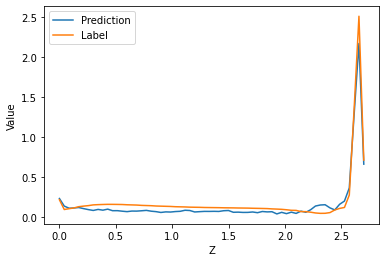

In [40]:
# 위에서 정의한 단면에 대해 라인별로 확인

# y고정
position_y = 0
default_y = sorted(list(set(df["y"]))) # 고정될 y값 (xz 단면을 보기위해)
condition_y = (df["y"]==default_y[position_y]) # y 조건 정의
x = df[condition_y]["x"]

# x고정
position_x = 7
default_x = sorted(list(set(x)))
condition_x = (df["x"]==default_x[position_x])

# z값과 plot할 대상
z = df[condition_x & condition_y]["z"]
pred = df[condition_x & condition_y]["prediction"]
label = df[condition_x & condition_y]["label"]

# plot
plt.plot(z,pred,label="Prediction")
plt.plot(z,label,label='Label')
plt.legend()
plt.xlabel("Z")
plt.ylabel("Value")

## 7. Interpolation & Extrapolation

- 장애물없는 데이터경우 사용된 값 목록
- 입구속도 : 1.43 1.67 1.91 2.15 2.38
- 입구온도 : 10 30 50
- 벽온도 : 10 30 50
- 각도 : 20 30 40 50 60 70 80
- 장애물있는 데이터경우 사용된 값 목록
- 입구속도 : 1.43 1.91 2.38
- 입구온도 : 10 고정
- 벽온도 : 30 고정
- 각도 : 30 50 70

(0) 비교하기 위한 조건별 레이블 데이터 로드

In [41]:
# -------최초 한번만 실행-------
# [기준] 레이블 역스케일링
Y_IE_label = label_data

for i in range(len(Y_IE_label)):
    Y_IE_label[i]=(Y_IE_label[i]*(max_label-min_label)+min_label)

장애물없는 데이터입니다.
========시뮬레이션 조건========
File name            dp007.txt
inlet_velocity            2.38
inlet_temperature           50
wall_temperature            30
Angle                       50
Name: 7, dtype: object
======== 공간구조 확인 ========


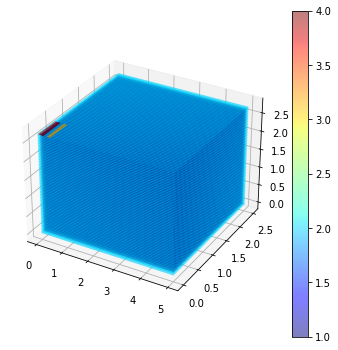

In [64]:
plot_num = 7
df = check_simulation_info(plot_num,csv_lst,simulation_df_no_obs,simulation_df_yes_obs,boundary_data)

(1) 내삽외삽 위한 데이터 생성

In [60]:
# 데이터생성
IE_boundary=boundary_data[plot_num:plot_num+1] 
IE_spe_tok=special_token[plot_num:plot_num+1]

# 입구속도 입구온도 벽온도 각도 None 
IE_spc_val=np.array([1.43, 10, 30, 80, 0.])
IE_spc_val=scaling_for_IE_ploation(IE_spc_val,driving_config)

# 데이터구성
X_IE_polation=[IE_boundary,IE_spe_tok,IE_spc_val]

# 예측
Y_IE_polation=model.predict(X_IE_polation,batch_size=1)

# 예측값 역스케일링
for i in range(len(Y_IE_polation)):
    Y_IE_polation[i]=(Y_IE_polation[i]*(max_label-min_label)+min_label)

(2) 테스트 결과 플롯

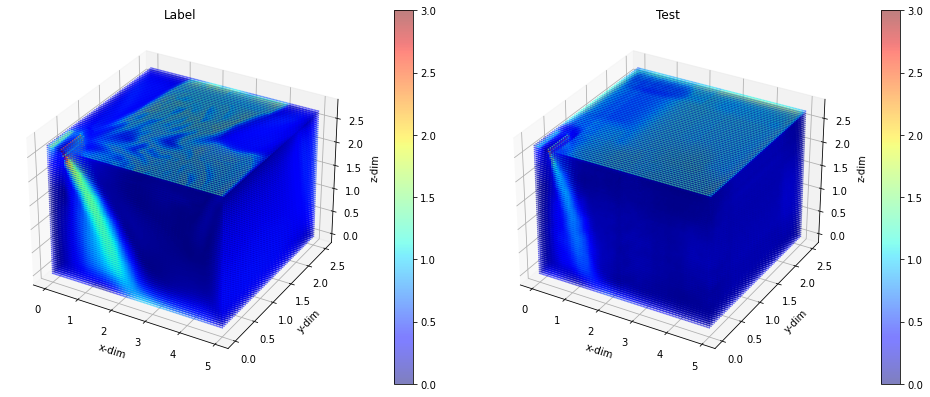

In [61]:
# Scatter 로 결과확인
fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(121, projection='3d')
im = ax.scatter3D(df["x"],df["y"],df["z"],zdir='z', c=Y_IE_label[plot_num], cmap='jet', s=0.5, alpha=0.5, vmin=0, vmax=3)
plt.title("Label")
ax.set_xlabel("x-dim")
ax.set_ylabel("y-dim")
ax.set_zlabel("z-dim")
plt.colorbar(im, fraction=0.046, pad=0.1)

ax = fig.add_subplot(122, projection='3d')
im = ax.scatter3D(df["x"],df["y"],df["z"], zdir='z', c=Y_IE_polation, cmap='jet', s=0.5, alpha=0.5, vmin=0, vmax=3)
plt.title("Test")
ax.set_xlabel("x-dim")
ax.set_ylabel("y-dim")
ax.set_zlabel("z-dim")
plt.colorbar(im, fraction=0.046, pad=0.1)

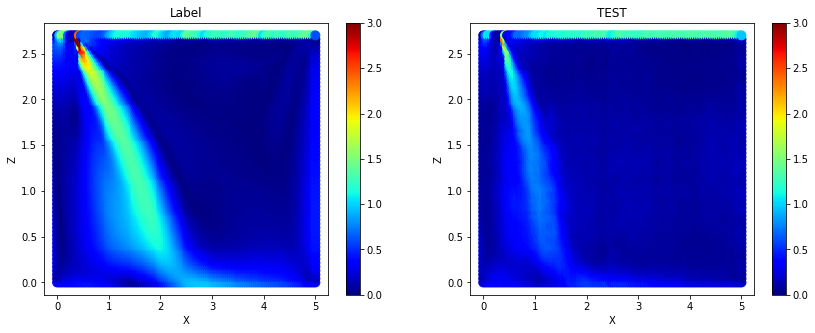

In [62]:
# 단면으로 결과확인
df["prediction"]=Y_IE_polation.reshape(x_dim*y_dim*z_dim)
df["label"]=Y_IE_label[plot_num].reshape(x_dim*y_dim*z_dim)

position_y = 0
default_y = sorted(list(set(df["y"]))) # 고정될 y값 (xz 단면을 보기위해)
condition_y = df["y"]==default_y[position_y] # y 조건 정의
x = df[condition_y]["x"]
z = df[condition_y]["z"]
pred = df[condition_y]["prediction"]
label = df[condition_y]["label"]

plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
plt.scatter(x,z,c=label, marker="o", s=80, cmap='jet', label="Label", vmin=0, vmax=3)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Label")

plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(x,z,c=pred, marker="o", s=80, cmap='jet', label="prediction", vmin=0, vmax=3)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("TEST")
plt.colorbar()